## GLIMS region files download: Level 0 files

This script creates "Level 0" RGI files. These files are fetched directly from the GLIMS database, subsetted with a spatial bounding box around each region.

Level 0 files need to be updated to reflect new entries into the GLIMS database.

In [1]:
from glims_database_dump import *
import geopandas as gpd
import shutil
from utils import mkdir
import numpy as np

In [2]:
servers = {
        'production': 'www.glims.org/services',
        'blue': 'blue.glims-services.apps.int.nsidc.org',
        'integration': 'integration.glims-services.apps.int.nsidc.org',
        'qa': 'qa.glims-services.apps.int.nsidc.org',
        'staging': 'staging.glims-services.apps.int.nsidc.org',
        }

## RGI Region files 

In [3]:
# go down from rgi7_scripts/workflow/preprocessing
data_dir = '../../../rgi7_data/'

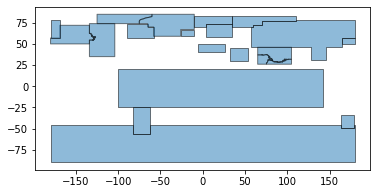

In [4]:
reg_file = os.path.join(data_dir, 'l0_regions', '00_rgi70_regions', '00_rgi70_O1Regions.shp')
reg_f = gpd.read_file(reg_file)
reg_f.plot(alpha=0.5, edgecolor='k');

These are the two regions with more than one box Region 01 and region 10:

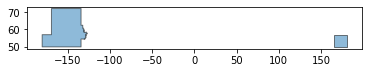

In [5]:
reg_f.loc[[0, 1]].plot(alpha=0.5, edgecolor='k');

In [6]:
# We drop the second alaska box which is useless
reg_f = reg_f.drop(1)

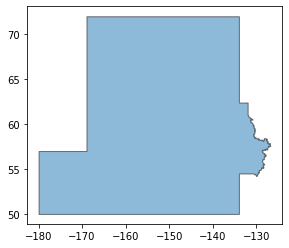

In [7]:
reg_f.loc[[0]].plot(alpha=0.5, edgecolor='k');

The Alaska box 1 has no glaciers in GLIMS to date (07.06.2021), you'll need to remove it otherwize the download will stall.

Region 10 has two boxes with glaciers in it:

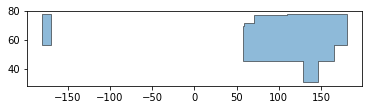

In [8]:
reg_f.loc[[10, 11]].plot(alpha=0.5, edgecolor='k');

## Download loop 

In [9]:
# If you want to (re-)download only selected regions
reg_f = reg_f.loc[6:7]

In [10]:
reg_f

,FULL_NAME,RGI_CODE,WGMS_CODE,geometry
6,Iceland,06,ISL,"POLYGON ((-26.00000 59.00000, -26.00000 60.000..."
7,Svalbard and Jan Mayen,07,SJM,"POLYGON ((-10.00000 70.00000, -10.00000 71.000..."


In [11]:
buffer = 0.5  # in degrees, buffer around the box
from_glims = mkdir(os.path.join(data_dir, 'l0_from_glims'))

for i, reg in reg_f.iterrows():
    
    # Prepare bounds 
    x0, y0, x1, y1 = reg.geometry.bounds
    
    x0 = np.clip(x0 - buffer, -180., None)
    y0 = np.clip(y0 - buffer, -90., None)
    x1 = np.clip(x1 + buffer, None, 180.)
    y1 = np.clip(y1 + buffer, None, 90.)
    
    bounds = f' {x0:.2f},{y0:.2f},{x1:.2f},{y1:.2f}'
    print('')
    print('{}, {}. Bounds: {}'.format(reg.RGI_CODE, reg.FULL_NAME, bounds))
        
    # GLIMS request arguments
    p = setup_argument_parser()
    args = p.parse_args(['--mode', 'glims',
                         '--nunataks', 'GLIMS',  # We can't use GLIMS because it is buggy 
                         '--archive_type', 'tar',
                         '--download_type', 'extent',
                         '--clause', bounds])

    server = servers[args.env]

    filebasename = issue_order(server, args)
    poll_readiness(server, filebasename, period=2, tries=args.tries, protocol=args.protocol)    # returns when file is ready
    do_download(server, filebasename, args)
    
    shutil.move(filebasename, os.path.join(from_glims, '{:02d}_RGI{:02d}.tgz'.format(i, int(reg['RGI_CODE']))))


06, Iceland. Bounds:  -26.50,58.50,-9.50,67.50
Issuing order to downloadprepare service at URL:
http://www.glims.org/services/downloadprepare?download_type=extent&clause=-26.50,58.50,-9.50,67.50&archive_type=tar&file_format=shapefile&data_model=GLIMS&glims_v_rgi=glims&rgidate=2000-09-01
Response:   b'{"filename":"glims_download_20594.tgz"}\n'
Try #   1:  False.  File name:  glims_download_20594.tgz
Try #   2:  False.  File name:  glims_download_20594.tgz
Try #   3:  False.  File name:  glims_download_20594.tgz
Try #   4:  False.  File name:  glims_download_20594.tgz
Try #   5:  False.  File name:  glims_download_20594.tgz
Try #   6:  False.  File name:  glims_download_20594.tgz
Try #   7:  False.  File name:  glims_download_20594.tgz
Try #   8:  False.  File name:  glims_download_20594.tgz
Try #   9:  False.  File name:  glims_download_20594.tgz
Try #  10:  False.  File name:  glims_download_20594.tgz
Try #  11:  True.  File name:  glims_download_20594.tgz
Retrieving file to  ./glims_

In [13]:
os.path.join(from_glims, '{:02d}_RGI{:02d}.tgz'.format(i, int(reg['RGI_CODE'])))

'../../../rgi7_data/l0_from_glims/07_RGI07.tgz'